# scipy.optimize

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import optimize

This subpackage contains optimization schemes for both scalar and multivariate functions.

--- 

## Function minimization

A number of the routines in this subpackage are for minimizing functions. Let's start with a simple example: a quadratic function.

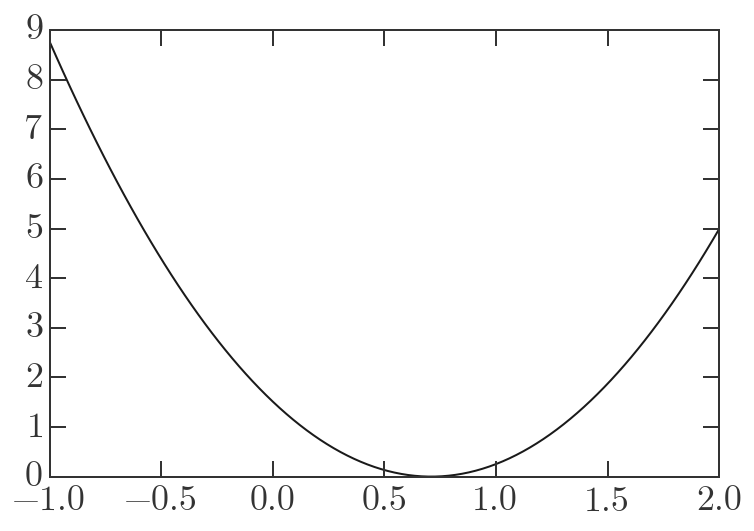

In [9]:
def f(x):
    return 3*(x - 0.71)**2

x = np.linspace(-1, 2, 100)
plt.plot(x, f(x), marker=None)

In [10]:
res = optimize.fmin(f, x0=0., disp=False)
print(res)

[ 0.71]


---

## Bounded minimization

Let's imagine the function we're trying to minimize has multiple minima, and we'd like to find the minimum between a particular set of bounds. For example, the function below:

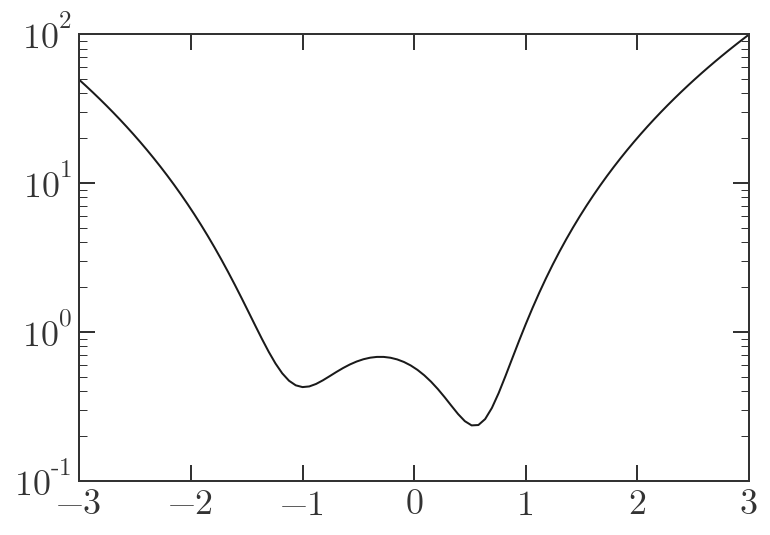

In [11]:
def f2(x):
    return x**4 + (x - 0.5)**3 + 0.7*(x-1)**2

x = np.linspace(-3, 3, 100)
plt.semilogy(x, f2(x), marker=None)

Let's say we want to find the minimum between -2 and -0.5 -- we can use `brent()` to specify a bounds to minimize over:

In [12]:
res = optimize.brent(f2, brack=(-2,0))
print(res)

-0.988360677569


---

## Solving functions

`fsolve()` finds the roots of a function $f(x) = 0$ given an initial guess. For example, let's consider the Kepler problem in its simplest form:

$$
M = E - \epsilon \sin E
$$

($M$ is the mean anomaly, $E$ is the eccentric anomaly, and $\epsilon$ is the eccentricity of the orbit). For a given eccentricity and mean anomaly, we can solve for the eccentric anomaly by solving for the roots of:

$$
f(E) = E - \epsilon \sin E - M = 0
$$

In [13]:
def kepler(E, eps, M):
    return E - eps*np.sin(E) - M

In [14]:
optimize.fsolve(kepler, x0=0., args=(0.1, 1.))

array([ 1.08859775])

---

## Least-squares fitting

Minimize the sum of squares of the residuals between function values and some data. This uses the Levenberg-Marquardt algorithm, which works even for nonlinear least-squares problems. If your problem is linear, you should probably just use [linear algebra](http://arxiv.org/abs/1008.4686).

To demonstrate how to use `leastsq()`, let's first generate some data:

In [15]:
def model(x, A, ph):
    # A : amplitude
    # ph : phase
    return A * np.cos(2*np.pi * x + ph)

<Container object of 3 artists>

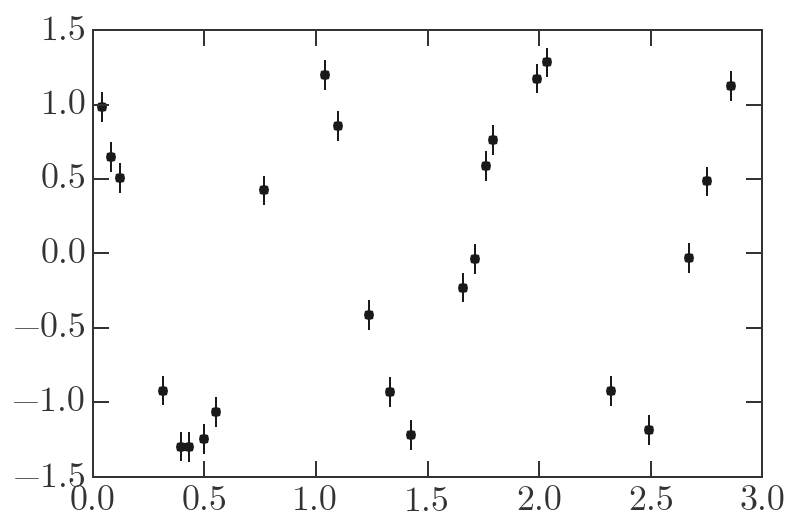

In [16]:
npts = 25
true_A = 1.3
true_ph = 0.35

x = np.random.uniform(0, 3., npts)
y = model(x, true_A, true_ph)

# "observe" the data with some uncertainties
sigma = 0.1
y = np.random.normal(y, sigma)

plt.errorbar(x, y, sigma, linestyle='none', marker='o')

We now define a function to compute the residuals between the data and the model with a given set of parameters (the error function):

In [17]:
def error_func(params, x, y, sigma):
    return -((y - model(x, *params)) / sigma)**2

In [18]:
p_opt, ier = optimize.leastsq(error_func, [1., 0.5], args=(x, y, sigma))

In [19]:
print(p_opt)

[ 1.2846788   0.33549779]


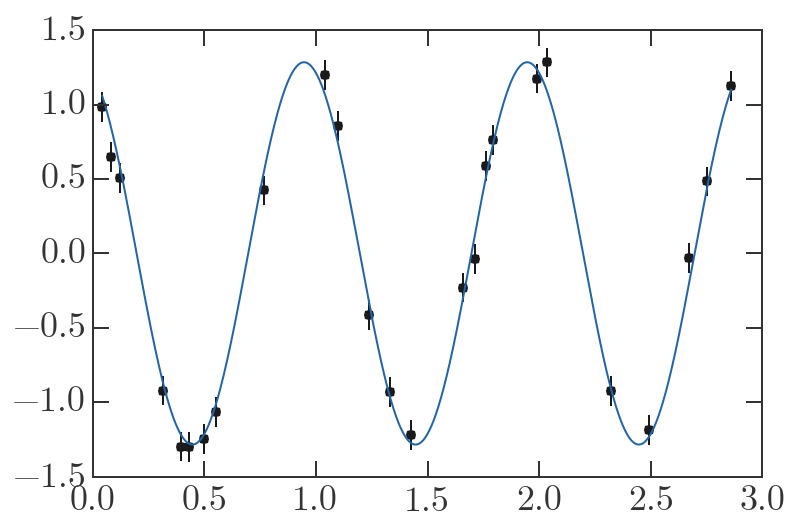

In [20]:
x_opt = np.linspace(x.min(), x.max(), 1000)
y_opt = model(x_opt, *p_opt)
plt.errorbar(x, y, sigma, linestyle='none', marker='o')
plt.plot(x_opt, y_opt, linestyle='-', marker=None)

---

<h1 style='background-color: #cccccc; padding: 15px;'>Exercises</h1>

For the exercises below, we're going to `scipy.optimize.leastsq` to fit an absorption line model to a small section of a spectrum. Let's start by downloading a spectrum to use:

In [21]:
# both of these are standard-library
import urllib2
from cStringIO import StringIO

# yep, using astropy before we've covered astropy...
from astropy.io import fits

In [22]:
url = "http://mirror.sdss3.org/sas/dr12/sdss/spectro/redux/26/spectra/2393/spec-2393-54156-0622.fits"
response = urllib2.urlopen(url)
file_obj = StringIO()
file_obj.write(response.read())
file_obj.seek(0)

Now, `file_obj` is a file object that contains the FITS file data from the URL we specified -- we can read the FITS file using Astropy

In [23]:
hdulist = fits.open(file_obj) # read file object as a FITS file
data = hdulist['coadd'].data # get data from the 'coadd' key of the HDUList

Here we extract the relevant columns out of the HDU containing the spectrum itself:

(3500, 9500)

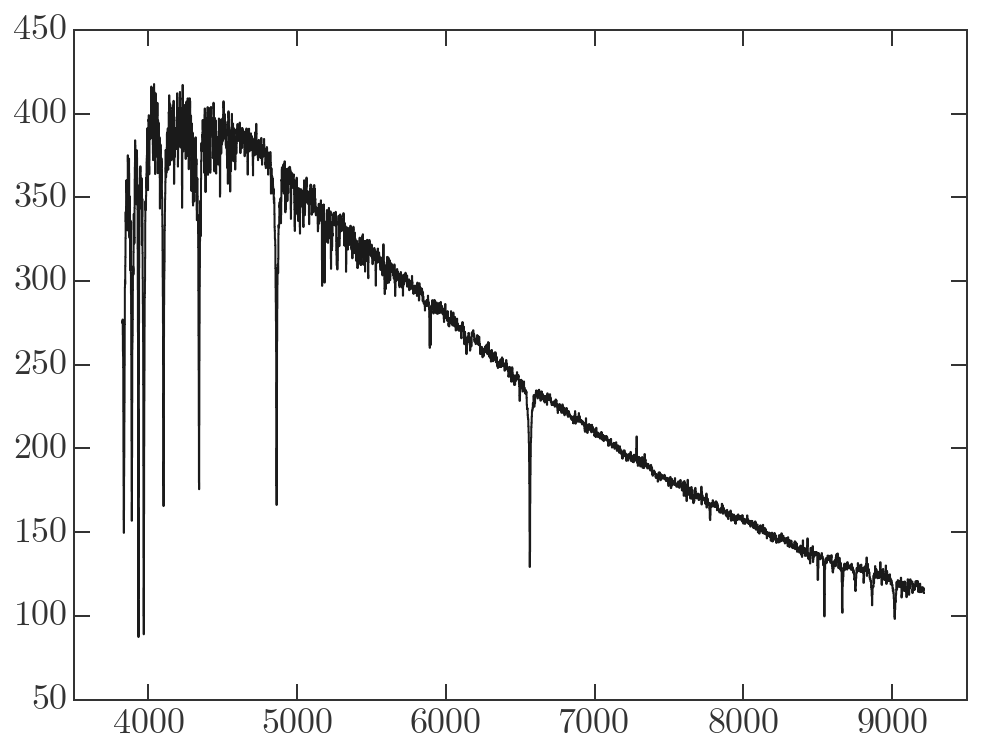

In [24]:
wvln = 10**data['loglam'] # log-wavelength (Angstroms)
flux = data['flux'] # flux
ivar = data['ivar'] # inverse variance

plt.figure(figsize=(8,6))
plt.plot(wvln, flux, drawstyle='steps', marker=None)
plt.xlim(3500, 9500)

Select a subset of the data $\pm$100 $\mathring {\rm A}$ around H$\alpha$ (6563 $\mathring {\rm A}$), store these as new variables (e.g., `wvln_Ha` and etc.). Plot the subset:

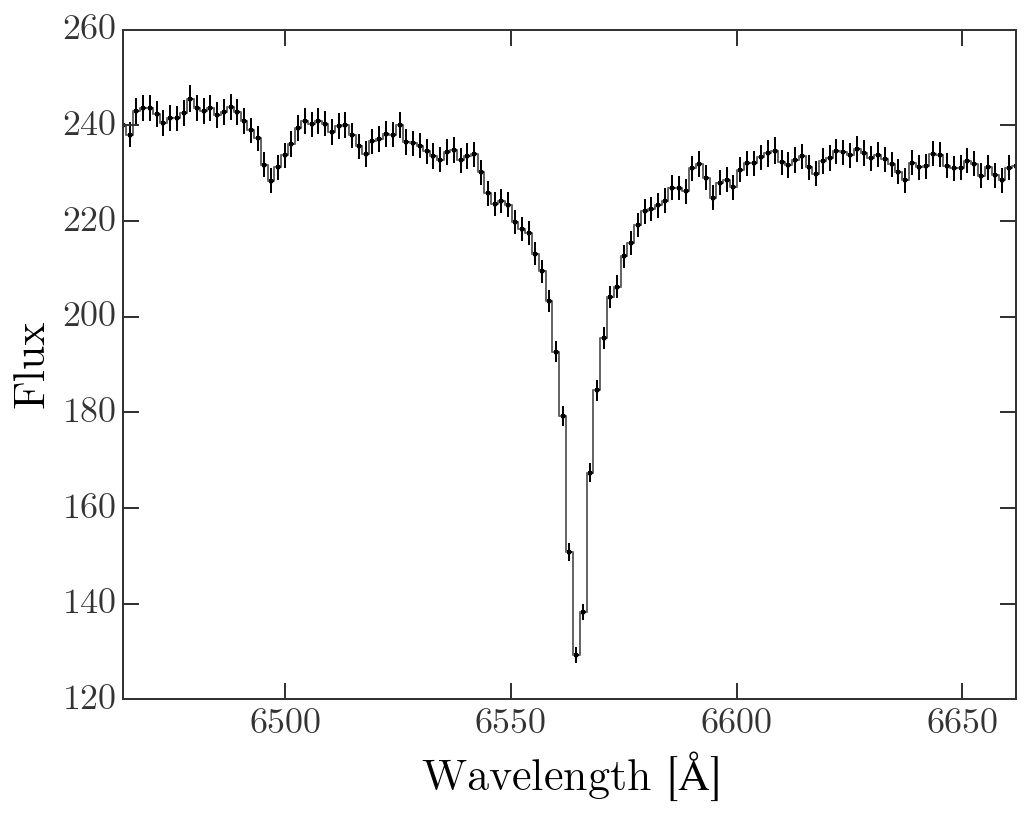

In [25]:
halpha = 6563.

ix = (wvln > (halpha - 100)) & (wvln < (halpha + 100))
wvln_Ha = wvln[ix]
flux_Ha = flux[ix]
ivar_Ha = ivar[ix]

plt.figure(figsize=(8,6))
plt.plot(wvln_Ha, flux_Ha, drawstyle='steps-mid', 
         marker=None, linewidth=1., color='#666666')
plt.errorbar(wvln_Ha, flux_Ha, 1/np.sqrt(ivar_Ha), 
             marker='.', linestyle='none', color='k')
plt.xlim(wvln_Ha.min(), wvln_Ha.max())
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"Flux")

Re-center the wavelength array so that H$\alpha$ is at 0/

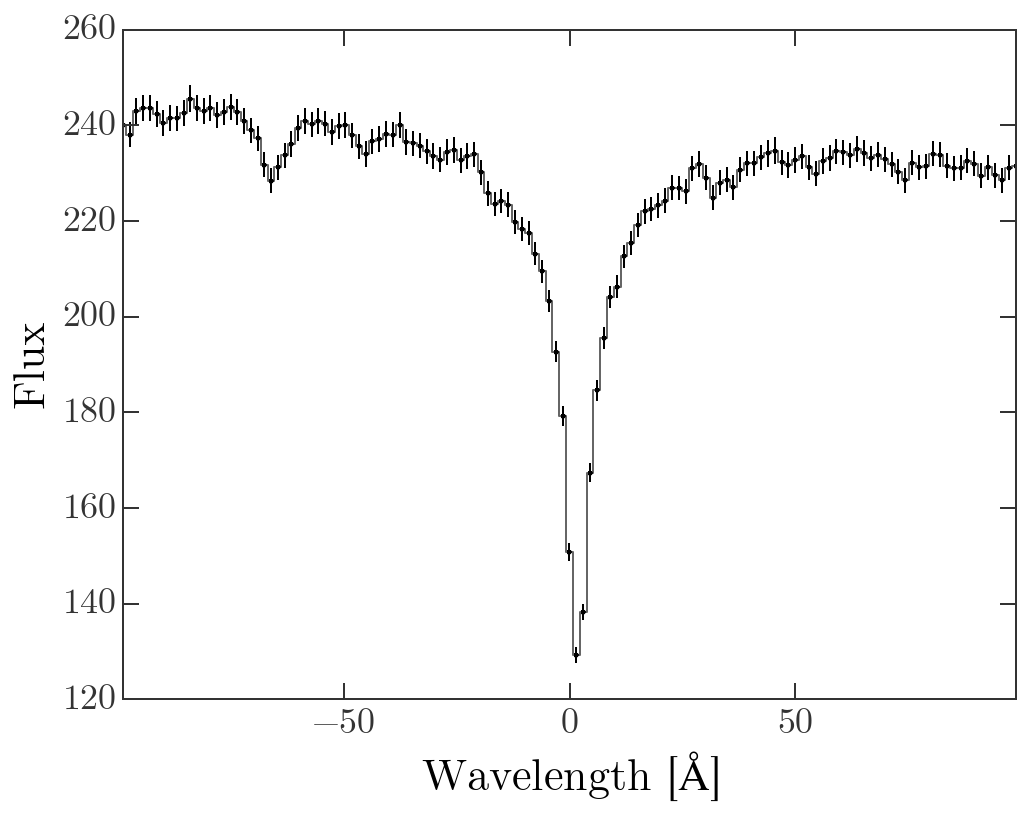

In [51]:
wvln_Ha = wvln_Ha - halpha

plt.figure(figsize=(8,6))
plt.plot(wvln_Ha, flux_Ha, drawstyle='steps-mid', 
         marker=None, linewidth=1., color='#666666')
plt.errorbar(wvln_Ha, flux_Ha, 1/np.sqrt(ivar_Ha), 
             marker='.', linestyle='none', color='k')
plt.xlim(wvln_Ha.min(), wvln_Ha.max())
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"Flux")

We are going to fit the absorption line using a Voigt profile plus a line (for the continuum). Start by writing a function `model()` that, given a set of parameters and a wavelength array, computes our model for the absorption line. I've provided a function below to compute the Voigt profile because it is a bit ugly...

In [29]:
from scipy.special import wofz

def voigt(wvln, amp, pos, fwhm, shape):
    shape_fac = 1j * shape * np.sqrt(np.log(2.))
    tmp = 1 / wofz(shape_fac).real
    tmp = tmp * amp * wofz(2*np.sqrt(np.log(2.)) * (wvln-pos)/fwhm + shape_fac).real
    return tmp

def model(params, wvln):
    """ 
    The parameters, params, will be:
        
        slope, intercept (for continuum)
        amplitude, position, fwhm, and shape (Voigt profile)
    """
    m,b,amp,pos,fwhm,shape = params
            
    return m * wvln + b + voigt(wvln, amp,pos,fwhm,shape)

Play with the parameters until you get something that qualitatively looks like the line above - do this by over-plotting the model over the 0-centered data:

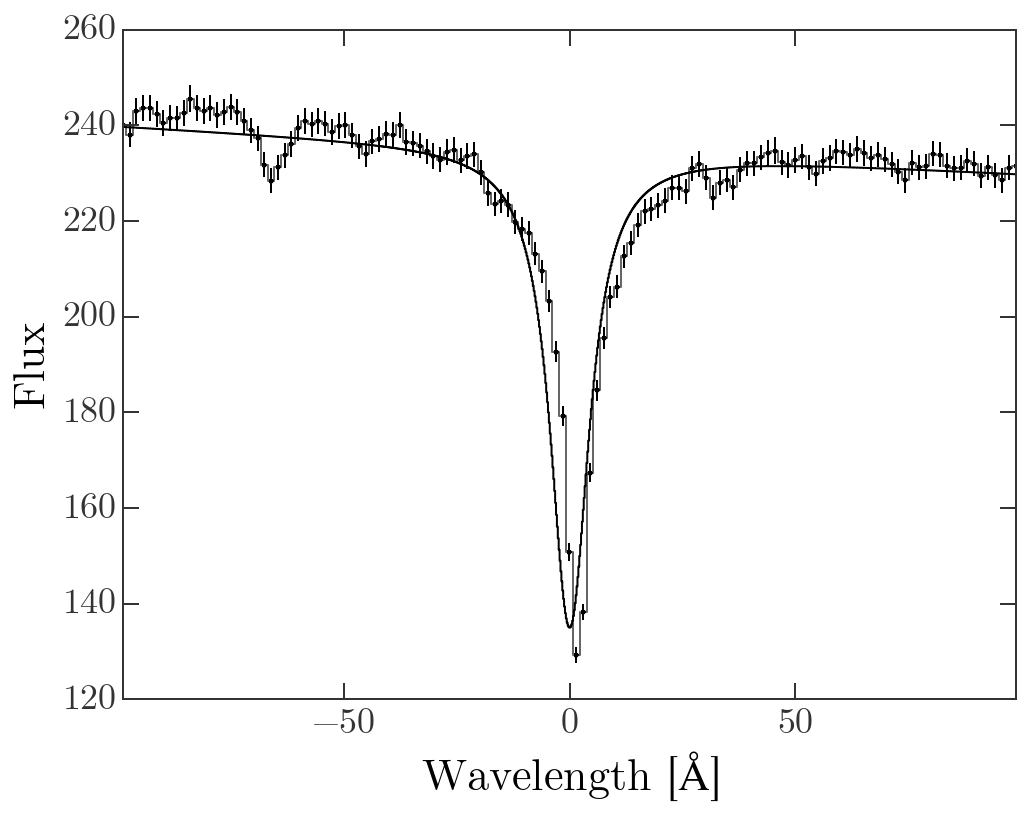

In [55]:
plt.figure(figsize=(8,6))
plt.plot(wvln_Ha, flux_Ha, drawstyle='steps-mid', 
         marker=None, linewidth=1., color='#666666')
plt.errorbar(wvln_Ha, flux_Ha, 1/np.sqrt(ivar_Ha), 
             marker='.', linestyle='none', color='k')

model_wvln = np.linspace(wvln_Ha.min(), wvln_Ha.max(), 1000)
p0 = [-0.05, 235., -100., 0., 2, 5.]
model_flux = model(p0, model_wvln)
plt.errorbar(model_wvln, model_flux, drawstyle='steps-mid', 
             marker=None, linewidth=1., color='k')

plt.xlim(wvln_Ha.min(), wvln_Ha.max())
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"Flux")

Now we're going to write a function that evaluates the logarithm of the likelihood of the data given a set of model parameters. In this case, we're going to assume we have Gaussian noise, so this is equivalent to chi-squared.

In [53]:
def ln_likelihood(params, wvln, flux, ivar):
    if params[4] < 0.:
        return np.inf
    return np.sqrt((model(params, wvln) - flux)**2 * ivar) # this is similar to chi-squared

Use `optimize.leastsq` to find the best-fit model

In [56]:
p_opt,ier = optimize.leastsq(ln_likelihood, x0=p0, 
                             args=(wvln_Ha, flux_Ha, ivar_Ha))

Plot your best-fit model over the data:

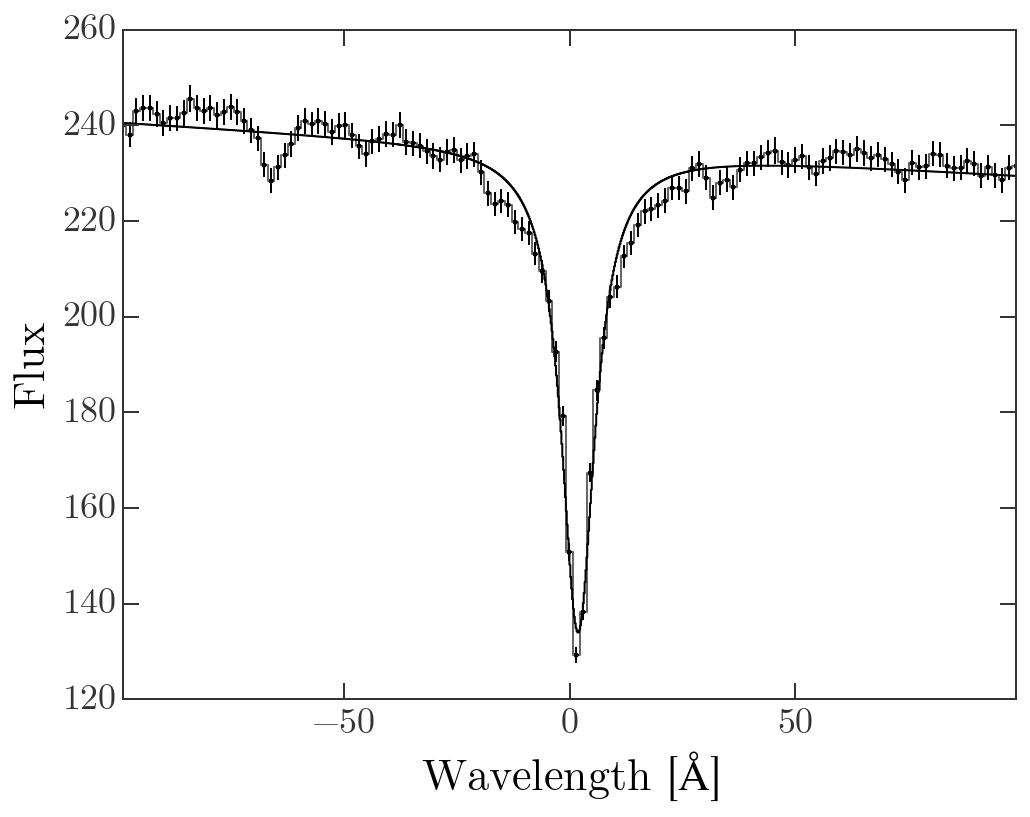

In [57]:
plt.figure(figsize=(8,6))
plt.plot(wvln_Ha, flux_Ha, drawstyle='steps-mid', 
         marker=None, linewidth=1., color='#666666')
plt.errorbar(wvln_Ha, flux_Ha, 1/np.sqrt(ivar_Ha), 
             marker='.', linestyle='none', color='k')

model_wvln = np.linspace(wvln_Ha.min(), wvln_Ha.max(), 1000)
model_flux = model(p_opt, model_wvln)
plt.errorbar(model_wvln, model_flux, drawstyle='steps-mid', 
             marker=None, linewidth=1., color='k')

plt.xlim(wvln_Ha.min(), wvln_Ha.max())
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"Flux")

## With MCMC ([emcee](https://github.com/dfm/emcee)) instead

We don't have time to go in to *why* you might want to use MCMC instead of maximum likelihood. For understanding the philosophical and mathematical difference (e.g., between Bayesian and Frequentist statistics), check out [this paper](http://arxiv.org/abs/1008.4686) by Hogg et al.

In [48]:
import emcee
import triangle # pip install triangle_plot

In [44]:
def ln_likelihood(params, wvln, flux, ivar):
    # equivalent to chi-squared
    return -(model(params, wvln) - flux)**2 * ivar

def ln_prior(params):
    if params[4] < 0.:
        return -np.inf
    return 0.
    
def ln_posterior(params, *args):
    lp = ln_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    
    ll = ln_likelihood(params, *args)
    if not np.all(np.isfinite(ll)):
        return -np.inf
    
    return lp + ll.sum()

In [45]:
nwalkers = 32
p0 = np.array([-0.05, 235., -100., 0., 2, 5.])
p0 = np.random.normal(p0, [0.001, 1., 1., 0.01, 0.1, 0.1], 
                      size=(nwalkers,len(p0)))

sampler = emcee.EnsembleSampler(nwalkers, dim=6, lnpostfn=ln_posterior,
                                args=(wvln_Ha, flux_Ha, ivar_Ha))

In [47]:
pos,xx,xx = sampler.run_mcmc(p0, 100)
sampler.reset()
pos,xx,xx = sampler.run_mcmc(pos, 1000)

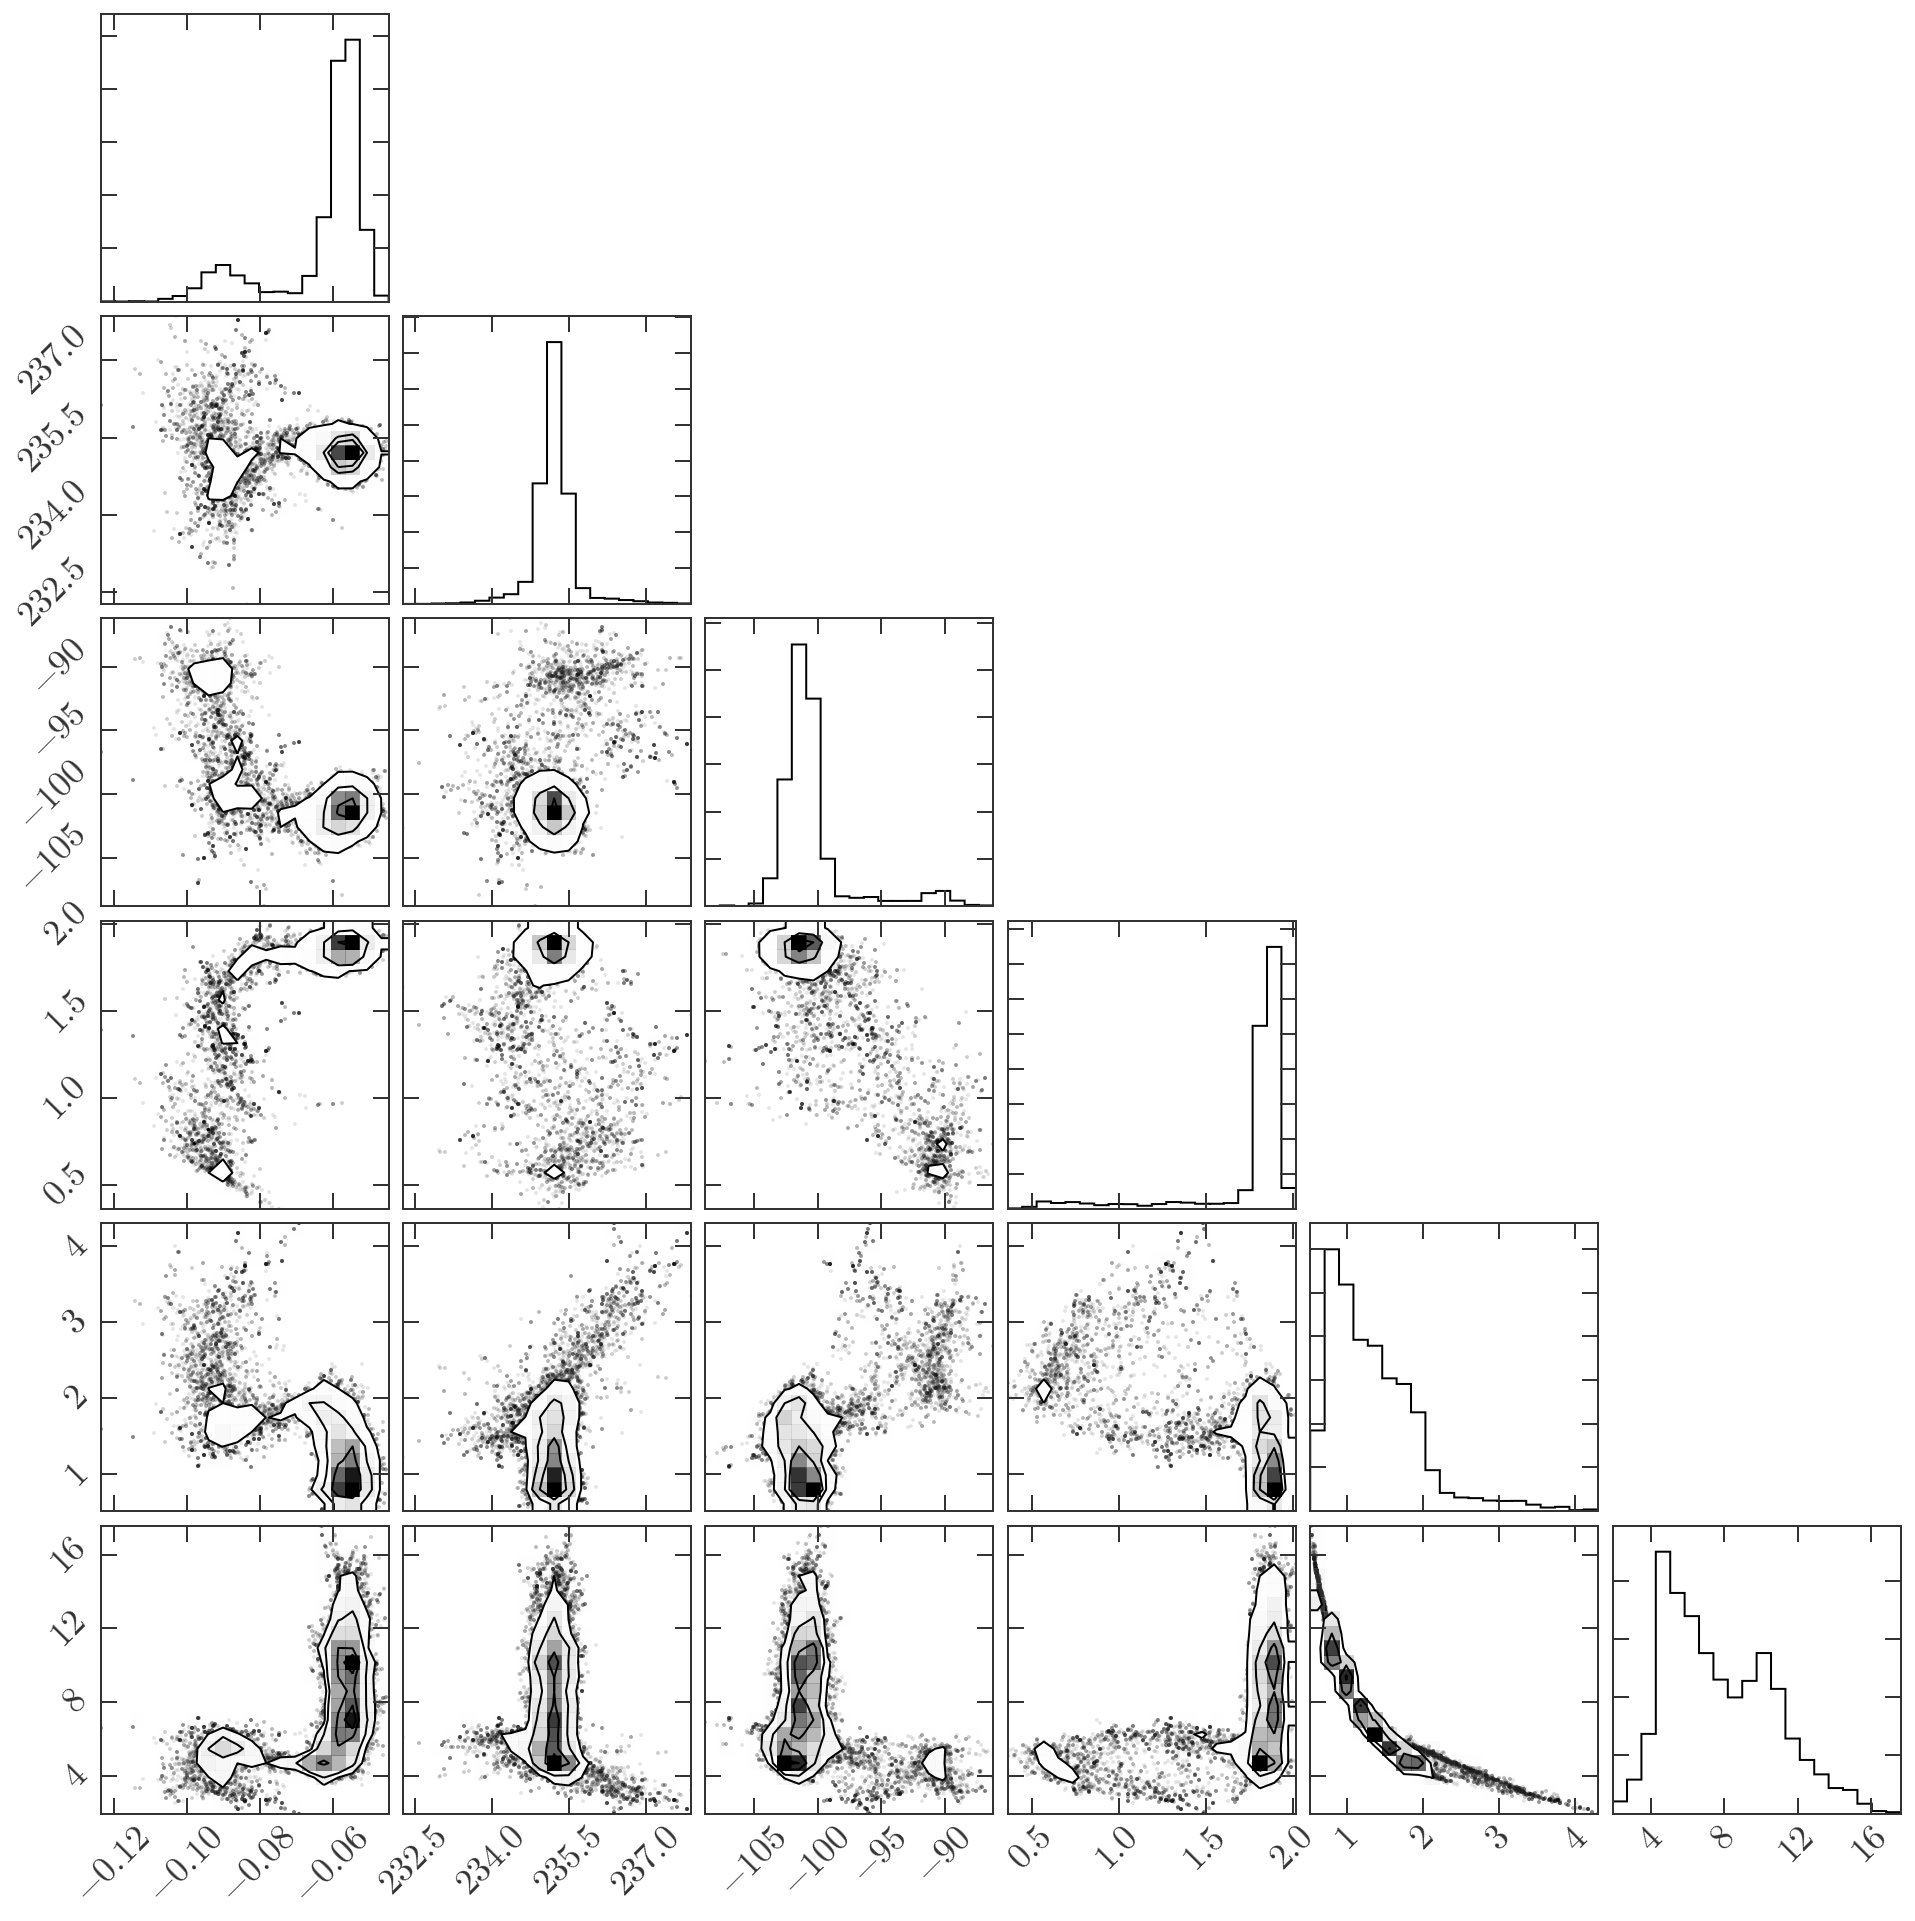

In [49]:
fig = triangle.corner(sampler.flatchain)